In [1]:
# Misc imports
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')
import torch
torch.set_printoptions(linewidth=200)
import seaborn as sns
sns.set_style("darkgrid")
import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
       '/storage'
))
import yaml
from pathlib import Path
# Local imports
from ese.scripts.utils import get_option_product
from ese.experiment.analysis.run_inference import get_cal_stats
from ese.experiment.analysis.analysis_utils.submit_utils import get_ese_inference_configs
# Ionpy imports
from ionpy.util import Config
from ionpy.analysis import ResultsLoader

# Define some useful paths.
scratch_root = Path("/storage/vbutoi/scratch/ESE")
code_root = Path("/storage/vbutoi/projects/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overridi

In [2]:
%%yaml inference_config

log:
    root: '?'
    gether_inference_stats: '?'
    summary_compute_global_metrics: '?' 
    min_fg_pixels: 0 
    log_interval: 20 
    log_image_stats: True 
    log_pixel_stats: True 
    track_ensemble_member_scores: False 

experiment:
    exp_root: '?'
    seed: 42

# For standard datasets
data:
    splits: ('val', 'cal')
    dset_type: 'standard'
    preload: False 

# For incontext datasets
# data:
#     splits: ('val',)
#     dset_type: 'incontext'
#     preload: False 

dataloader:
    batch_size: 1 
    num_workers: 0
    pin_memory: True 

<IPython.core.display.Javascript object>

In [3]:
%%yaml model_cfg

model:
    calibrator: '?'
    pretrained_exp_root : None
    checkpoint: 'max-val-dice_score' 
    pretrained_select_metric: "val-dice_score"


# model:
#     checkpoint: '?' 
#     calibrator: None
#     pretrained_exp_root : None
#     num_samples: 1
#     checkpoint: "max-val_od-dice_score"
#     _attr:
#         model: 'universeg.experiment.models.QCUNet3'
#         data_support_size: 64
#         mix_filters: (64, 64, 64, 64)

<IPython.core.display.Javascript object>

In [4]:
%%yaml ensemble_cfg

ensemble:
    combine_fn: '?'
    combine_quantity: '?'
    member_temps: None
    member_w_metric: None
    member_paths: None
    normalize: False

<IPython.core.display.Javascript object>

In [5]:
%%yaml calibration_cfg 

local_calibration:
    num_prob_bins: 15
    neighborhood_width: 3
    square_diff: False 

global_calibration:
    num_prob_bins: 15
    num_classes: '?' 
    neighborhood_width: 3
    square_diff: False 
    loss_weights: None 

<IPython.core.display.Javascript object>

In [6]:
exp_name = '04_05_24_RandomShapes_Evaluation'
group_dict = {
    "dataset": "Shapes",
    "exp_group": exp_name,
    "base_models_group": "03_26_24_RandomCircles_MassiveEnsemble",
    "calibrated_models_group": "03_26_24_RandomCircles_MassiveEnsemble_CE_Calibrated",
}

# exp_name = '04_04_24_WBC_UniverSeg_Inference'
# group_dict = {
#     "dataset": "WBC",
#     "exp_group": exp_name,
#     "base_models_group": "QC3Net_SupportSetAblation",
# }

In [7]:
%%yaml base_cfg_args

exp_opts:
    log.gether_inference_stats: [True]
    log.summary_compute_global_metrics: [True]
    data.subsplit: [0]

submit_opts:
    seed: 42
    gather_sub_runs: False
    scratch_root: '/storage/vbutoi/scratch/ESE'
    # scratch_root: '/storage/vbutoi/scratch/UniverSeg'
    # max_ensemble_samples: 5 
    # ens_cfg_options:
    #     - ('mean', 'probs')
    #     - ('max', 'probs')
    # num_ens_membs:
    #     - 2
    #     - 4
    #     - 8
    #     - 16
    #     - 32

<IPython.core.display.Javascript object>

In [8]:
%%yaml inference_config_opts

calibrator:
    - Uncalibrated
    # - TempScaling
    # - LTS

do_ensemble:
    # - True
    - False

<IPython.core.display.Javascript object>

### Standard Calibrators.

In [9]:
inference_func = get_cal_stats
# Get the configs for the different runs.
option_set = get_ese_inference_configs(
    group_dict=group_dict,
    inf_cfg_opts=inference_config_opts,
    base_cfg_args=base_cfg_args
)

Set seed: 42


In [10]:
len(option_set)

1

In [11]:
# Load the inference cfg from local.
##################################################
inf_cfg_root = code_root / "ese" / "experiment" / "configs" / "inference"

##################################################
with open(inf_cfg_root / "datasets" / f"{group_dict['dataset']}.yaml", 'r') as file:
    dataset_inference_cfg = yaml.safe_load(file)

with open(inf_cfg_root / "Calibration_Metrics.yaml", 'r') as file:
    cal_metrics_cfg = yaml.safe_load(file)

##################################################
base_cfg = Config(inference_config).update([calibration_cfg, model_cfg, ensemble_cfg, dataset_inference_cfg, cal_metrics_cfg])
# Get the configs
cfgs = get_option_product(exp_name, option_set, base_cfg)

## Running Jobs

In [12]:
from ese.experiment.analysis.run_inference import get_cal_stats

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Set seed: 45


/storage/vbutoi/projects/ionpy/util/libcheck.py:49: UserWarning: Intel MKL extensions not available for NumPy
  warn("Intel MKL extensions not available for NumPy")
/storage/vbutoi/projects/ionpy/util/libcheck.py:57: UserWarning: Using slow Pillow instead of Pillow-SIMD
  warn("Using slow Pillow instead of Pillow-SIMD")


Set seed: 42
Running:

data:
  dset_type: standard
  input_type: image
  preload: false
  splits: ('val', 'cal')
  subsplit: 0
dataloader:
  batch_size: 1
  num_workers: 0
  pin_memory: true
dataset:
  _class: ese.experiment.datasets.Shapes
  augmentations: null
  binarize: true
  dset_type: standard
  preload: false
  return_data_id: true
  subsplit: 0
  version: 3.0
ensemble:
  combine_fn: null
  combine_quantity: null
  member_paths: None
  member_temps: None
  member_w_metric: None
  normalize: null
experiment:
  dataset_name: Shapes
  exp_root: /storage/vbutoi/scratch/ESE/inference/04_05_24_RandomShapes_Evaluation
  pretrained_seed: 45
  seed: 42
global_cal_metrics:
- ECE:
    _fn: ese.experiment.metrics.ece.ece_loss
    cal_type: toplabel
- Edge-ECE:
    _fn: ese.experiment.metrics.ece.edge_ece_loss
    cal_type: toplabel
- CW-ECE:
    _fn: ese.experiment.metrics.ece.cw_ece_loss
    cal_type: classwise
    class_weighting: proportional
- ECW-ECE:
    _fn: ese.experiment.metrics.e

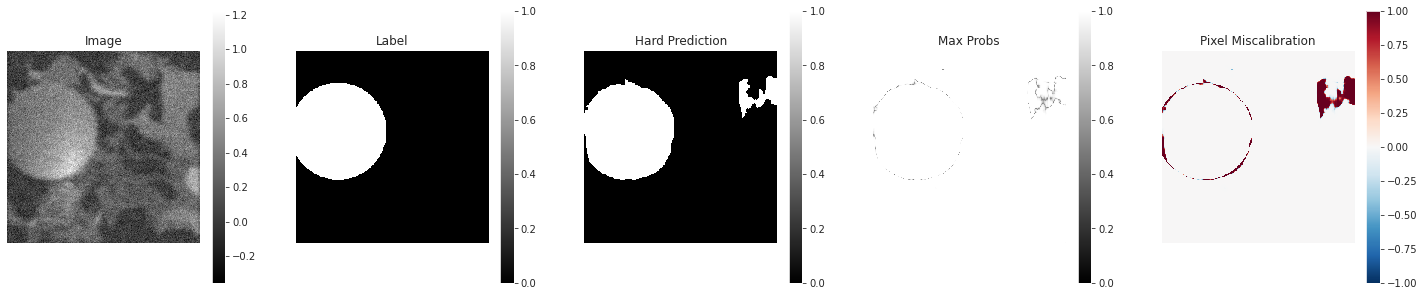

Dice: 0.9307193756103516
HD95: 135.91217041015625
BoundaryIOU: 0.13885673880577087
Accuracy: 0.9721221923828125
Recall: 0.9733502268791199
Precision: 0.891666054725647
Pixel-Ambiguity: None
Soft-Region-Ambiguity: None
Hard-Region-Ambiguity: None
Image_ECE: 0.025334731148177525
Image_Edge-ECE: 0.3077522351680942
Image_CW-ECE: 0.02590942569077015
Image_ECW-ECE: 0.03032192587852478
Image_Uniform-CW-ECE: 0.02590942569077015
Image_Uniform-ECW-ECE: 0.03130447492003441
[1]
479


IndexError: index 1 is out of bounds for axis 0 with size 1

In [13]:
from ese.experiment.experiment import run_ese_exp

###### Run individual jobs
run_ese_exp(
    config=cfgs[0], 
    job_func=get_cal_stats,
    run_name='debug',
    show_examples=True,
    gpu='3',
) 

In [ ]:
# from ese.experiment.experiment import submit_ese_exps 

# #### Run Batch Jobs
# submit_ese_exps(
#     config_list=cfgs,
#     job_func=get_cal_stats,
#     # available_gpus=['0', '1', '2', '3'],
#     available_gpus=['0', '1', '2', '3', '4', '5', '6', '7'],
# )